<a href="https://colab.research.google.com/github/HugoFromont/Project/blob/master/Clothing_recommendation/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Création d'un moteur de recommandation

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import tqdm

import requests
from io import BytesIO

## Importation des données

In [3]:
data = pd.read_json("https://raw.githubusercontent.com/HugoFromont/Project/master/Clothing_recommendation/data/lien_image.json")
data.head()

url  ... split
0  https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...  ...     7
1  https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...  ...     6
2  https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...  ...     2
3  https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...  ...     7
4  https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...  ...     7

[5 rows x 3 columns]

#### Téléchargement des images

In [ ]:
image = []

for i in tqdm.tqdm(range(0,len(data))):
  response = requests.get(data.url[i])
  img = Image.open(BytesIO(response.content))
  img = np.array(img.resize((224, 224)))
  img = img.astype('float16')/255
  image.append(img)

100%|██████████| 8792/8792 [09:10<00:00, 19.28it/s]


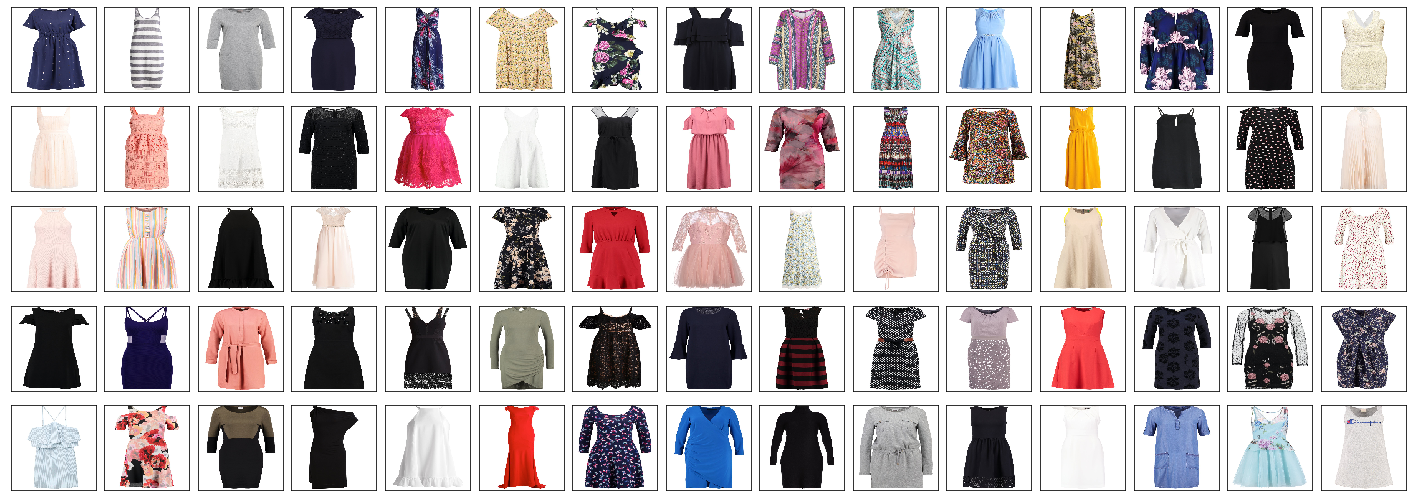

In [ ]:
fig = plt.figure(figsize=(25,9))
plt.gcf().subplots_adjust( wspace = 0.1, hspace = 0.1)
for i in range(1,76):
    plt.subplot(5, 15, i)
    img = plt.imshow((image[i]*255).astype(int))
    img.axes.get_xaxis().set_visible(False)
    img.axes.get_yaxis().set_visible(False)
plt.show()

## Feature Extraction

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16(include_top=True, weights='imagenet')
model.layers.pop()
model = Model(input=model.input,output=model.layers[-1].output)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
vgg16_features_image = model.predict(image)
print("Taile de vgg16_features_image : {}".format(vgg16_features_image.shape))

Taile de vgg16_features_image : (8792, 4096)


### Autoencodeur

In [ ]:
import tensorflow as tf

# Encodeur
input_img = tf.keras.Input(shape=(224,224,3))
Encod = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
Encod = tf.keras.layers.MaxPooling2D((2, 2))(Encod)
Encod = tf.keras.layers.Conv2D(5, (3, 3), padding='same', activation='relu')(Encod)
Encod = tf.keras.layers.MaxPooling2D((2, 2))(Encod)
Encod = tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='relu')(Encod)
Encod = tf.keras.layers.Flatten()(Encod)
Encod = tf.keras.layers.Dense(4096)(Encod)

# Decodeur
Decod = tf.keras.layers.Dense(6272)(Encod)
Decod = tf.keras.layers.Reshape((56, 56, 2))(Decod)
Decod = tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='relu')(Decod)
Decod = tf.keras.layers.UpSampling2D((2, 2))(Decod)
Decod = tf.keras.layers.Conv2D(5, (3, 3), padding='same', activation='relu')(Decod)
Decod = tf.keras.layers.UpSampling2D((2, 2))(Decod)
Decod = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(Decod)
Decod = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='relu')(Decod)


model = tf.keras.Model(input_img, Decod)
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 112, 112, 5)       725       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 5)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 56, 56, 2)         92        
_________________________________________________________________
flatten_9 (Flatten)          (None, 6272)              0  

In [ ]:
model.compile(optimizer="adam", loss="mse")
model.fit([image],image, batch_size = 100, epochs = 15, shuffle=True)

Train on 8792 samples
Epoch 1/15
8792/8792 [==============================] - 23s 3ms/sample - loss: 0.1471
Epoch 2/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0376
Epoch 3/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0301
Epoch 4/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0270
Epoch 5/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0247
Epoch 6/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0234
Epoch 7/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0224
Epoch 8/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0217
Epoch 9/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0209
Epoch 10/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0198
Epoch 11/15
8792/8792 [==============================] - 21s 2ms/sample - loss: 0.0192
Epoch 12/15
8792/8792 [=======

In [ ]:
Encodeur = tf.keras.Model(input_img, Encod)
encod_features_image = Encodeur.predict(image)

### Calcule de similarité

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vgg16_matrice_cos = cosine_similarity(vgg16_features_image)
encod_matrice_cos = cosine_similarity(encod_features_image)

In [ ]:
def extract_cos_vgg16(image_id, nb_simil = 5):
  score_vgg16 = pd.DataFrame({
      'score' : vgg16_matrice_cos[image_id], 
      'index' : np.arange(0,len(vgg16_matrice_cos))
      })
  score_vgg16 = score_vgg16.sort_values('score',ascending  = False)
  return((score_vgg16.index[1:nb_simil+1],score_vgg16.score[1:nb_simil+1]))


def extract_cos_encod(image_id, nb_simil = 5):
  score_encod = pd.DataFrame({
      'score' : encod_matrice_cos[image_id], 
      'index' : np.arange(0,len(encod_matrice_cos))
      })
  score_encod = score_encod.sort_values('score',ascending  = False)
  return((score_encod.index[1:nb_simil+1],score_encod.score[1:nb_simil+1]))

In [ ]:
def plot_similarite(image_id, nb_simil = 5):
  fig = plt.figure(figsize=(18,7))
  plt.gcf().subplots_adjust( wspace = 0.2, hspace = 0.2)

  # Image selectionnée
  plt.subplot(1, nb_simil +1, 1)
  plt.title('Image selectionnée')
  img = plt.imshow((image[image_id] * 255).astype(int))
  img.axes.get_xaxis().set_visible(False)
  img.axes.get_yaxis().set_visible(False)

  ##### VGG16 #####
  # Image similaire (cos metric)
  index_simi_img,score = extract_cos_vgg16(image_id = image_id, nb_simil = nb_simil)

  for i in range(len(index_simi_img)):
    plt.subplot(2, nb_simil +1, i+2)
    plt.title('VGG16 - Score : ' + str(round(score[index_simi_img[i]],2)))
    img = plt.imshow((image[index_simi_img[i]]*255).astype(int))
    img.axes.get_xaxis().set_visible(False)
    img.axes.get_yaxis().set_visible(False)

  ##### autoencod #####
  # Image similaire (cos metric)
  index_simi_img,score = extract_cos_encod(image_id = image_id, nb_simil = nb_simil)

  for i in range(len(index_simi_img)):
    plt.subplot(2, nb_simil +1, nb_simil +3 +i)
    plt.title('Encodeur - Score : ' + str(round(score[index_simi_img[i]],2)))
    img = plt.imshow((image[index_simi_img[i]]*255).astype(int))
    img.axes.get_xaxis().set_visible(False)
    img.axes.get_yaxis().set_visible(False)
  plt.show()

__________________________________________ Image numéro : 0 __________________________________________


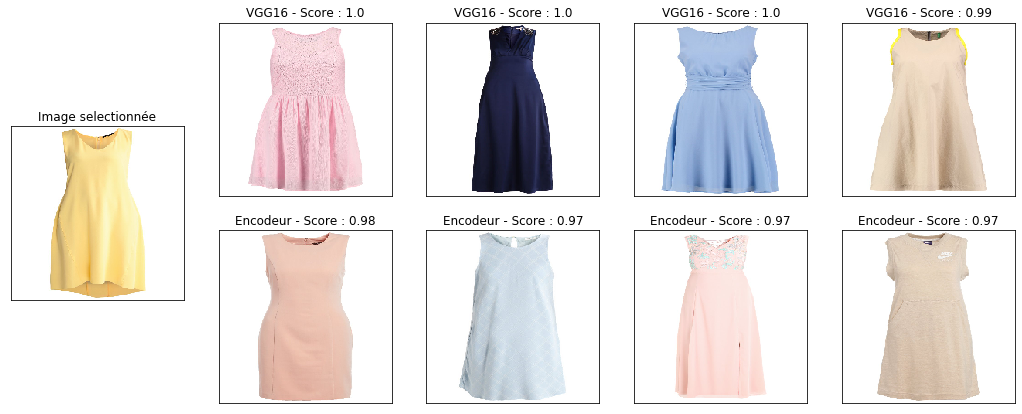

__________________________________________ Image numéro : 1 __________________________________________


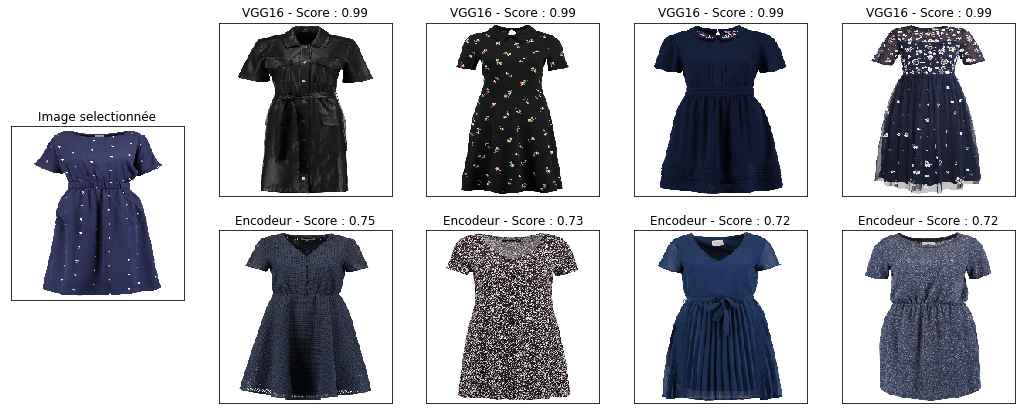

__________________________________________ Image numéro : 2 __________________________________________


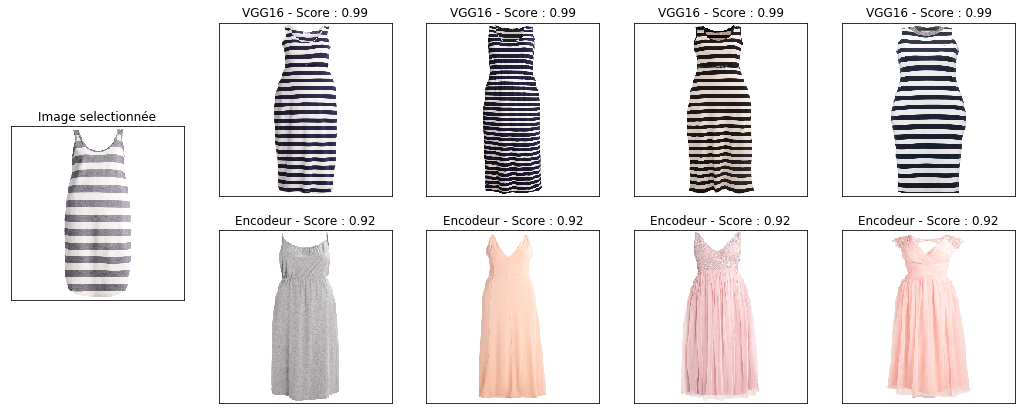

__________________________________________ Image numéro : 3 __________________________________________


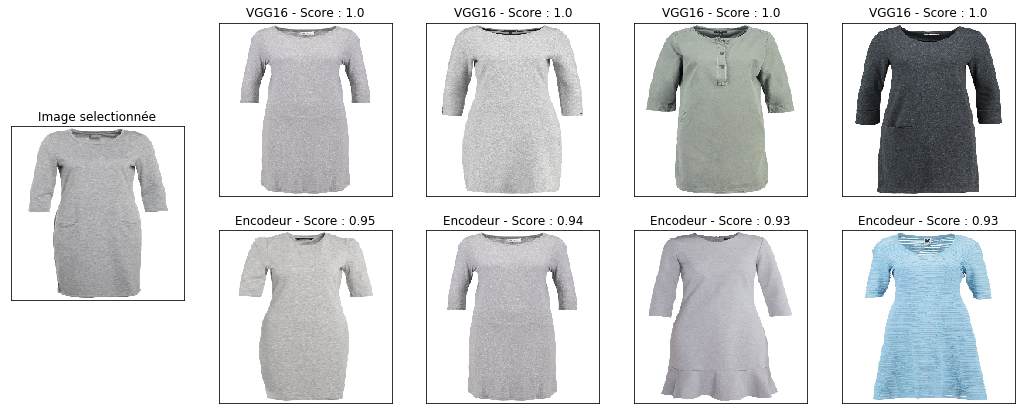

__________________________________________ Image numéro : 4 __________________________________________


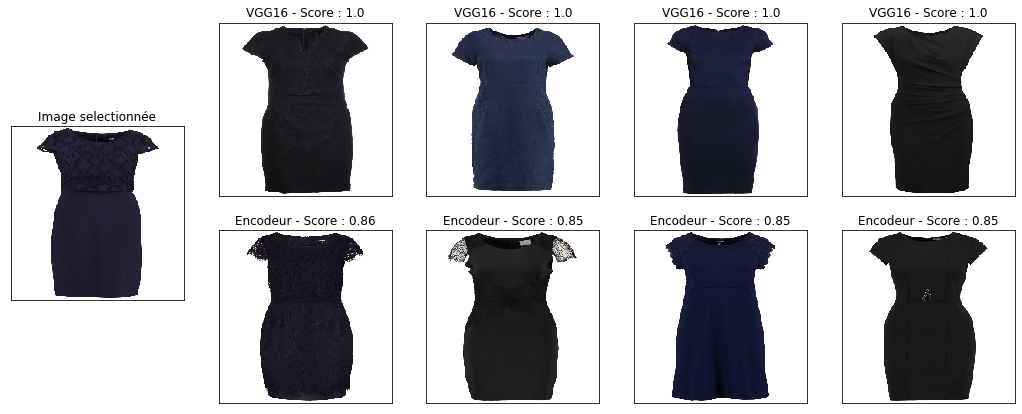

__________________________________________ Image numéro : 5 __________________________________________


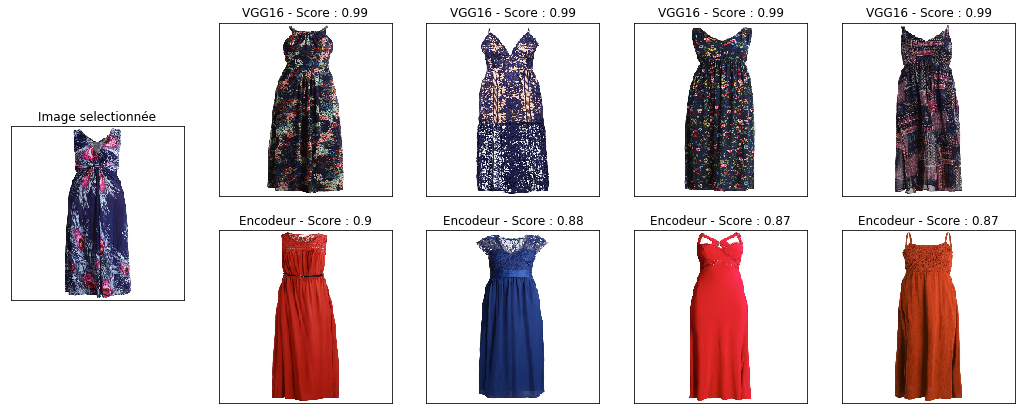

__________________________________________ Image numéro : 6 __________________________________________


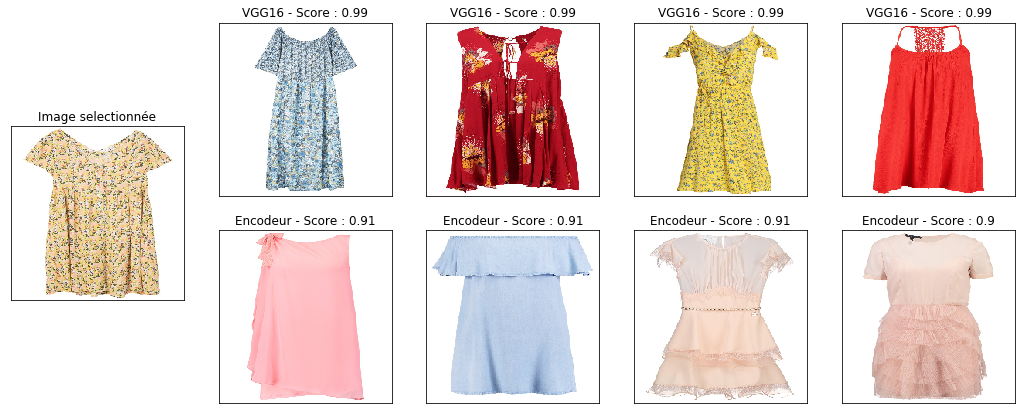

__________________________________________ Image numéro : 7 __________________________________________


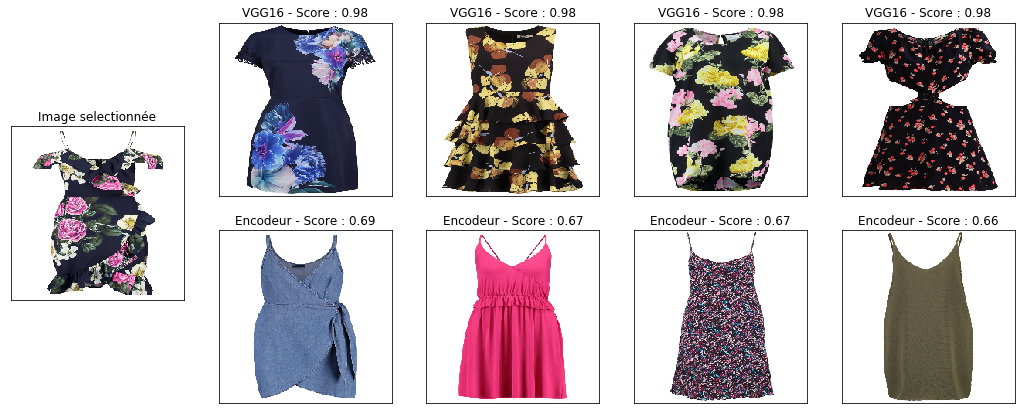

__________________________________________ Image numéro : 8 __________________________________________


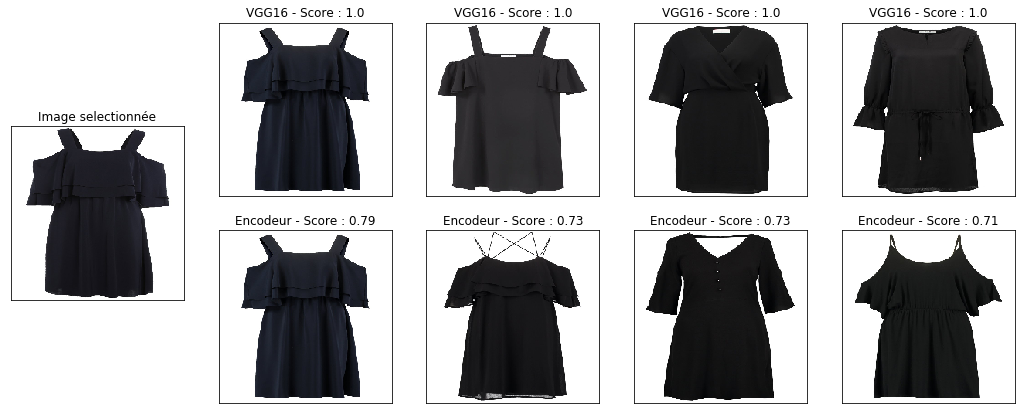

__________________________________________ Image numéro : 9 __________________________________________


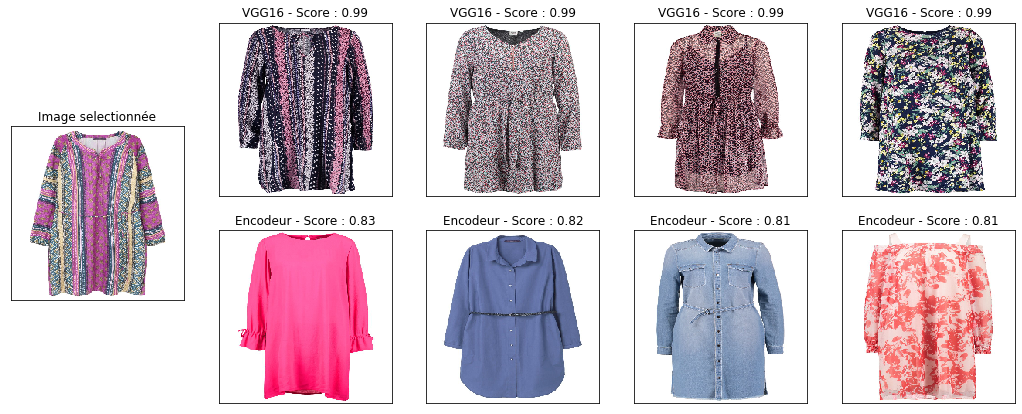

__________________________________________ Image numéro : 10 __________________________________________


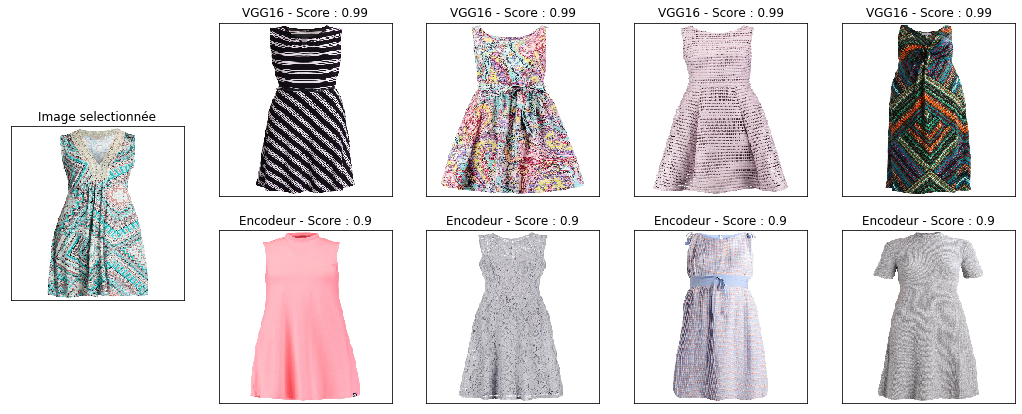

__________________________________________ Image numéro : 11 __________________________________________


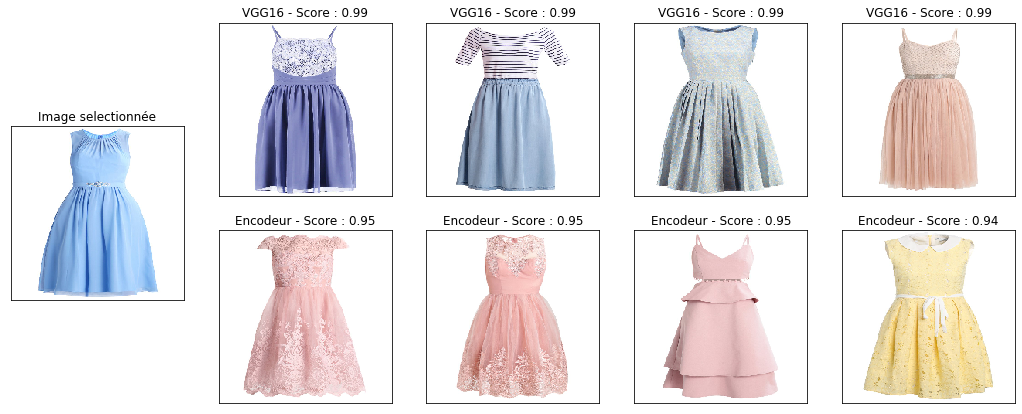

__________________________________________ Image numéro : 12 __________________________________________


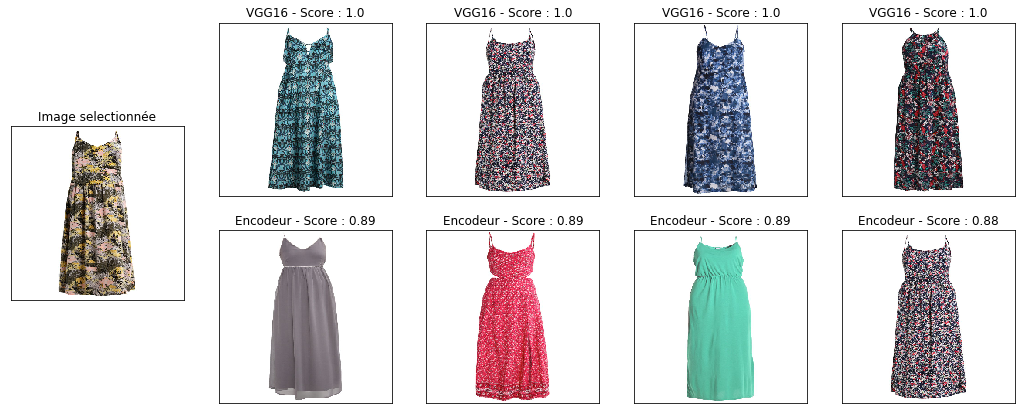

__________________________________________ Image numéro : 13 __________________________________________


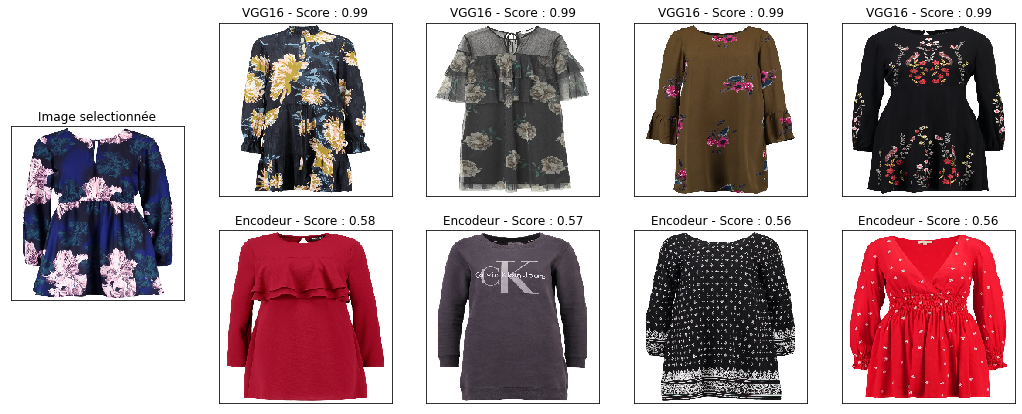

__________________________________________ Image numéro : 14 __________________________________________


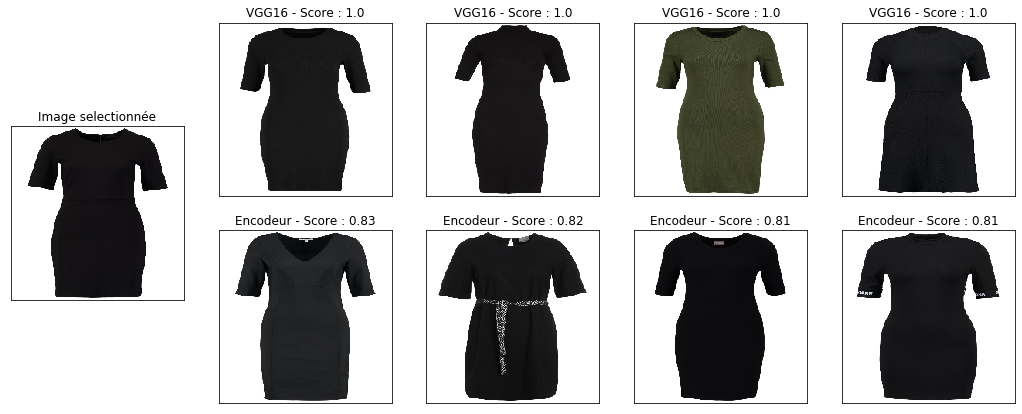

__________________________________________ Image numéro : 15 __________________________________________


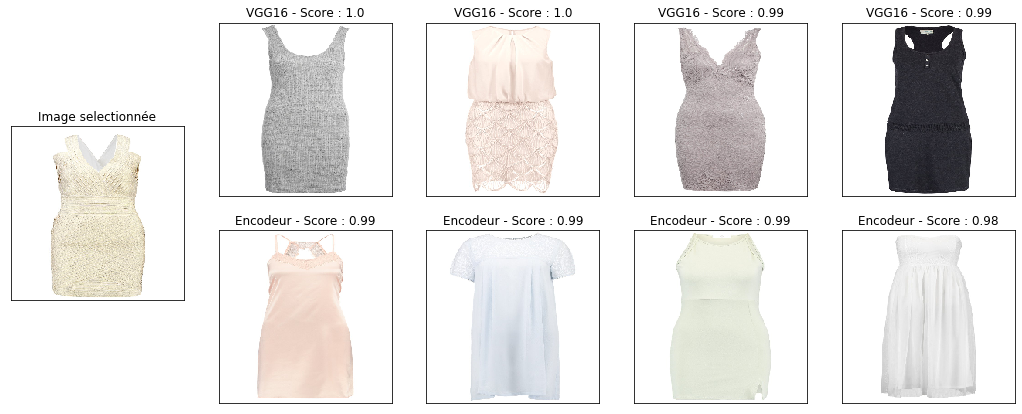

__________________________________________ Image numéro : 16 __________________________________________


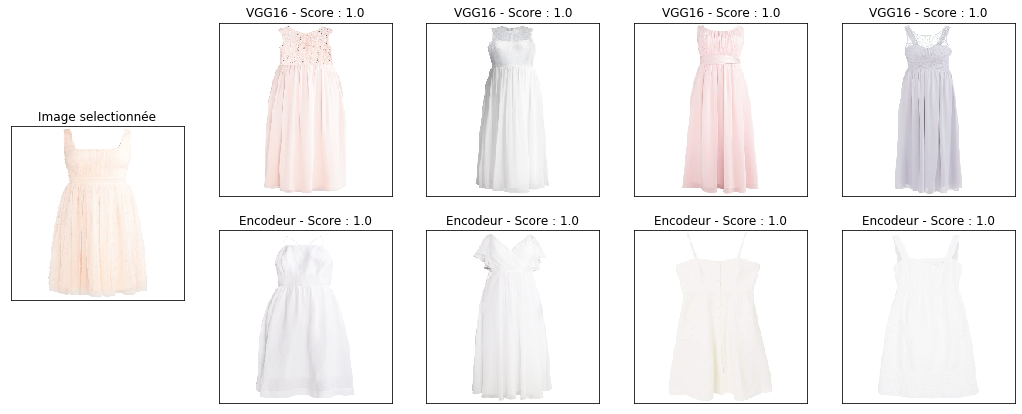

__________________________________________ Image numéro : 17 __________________________________________


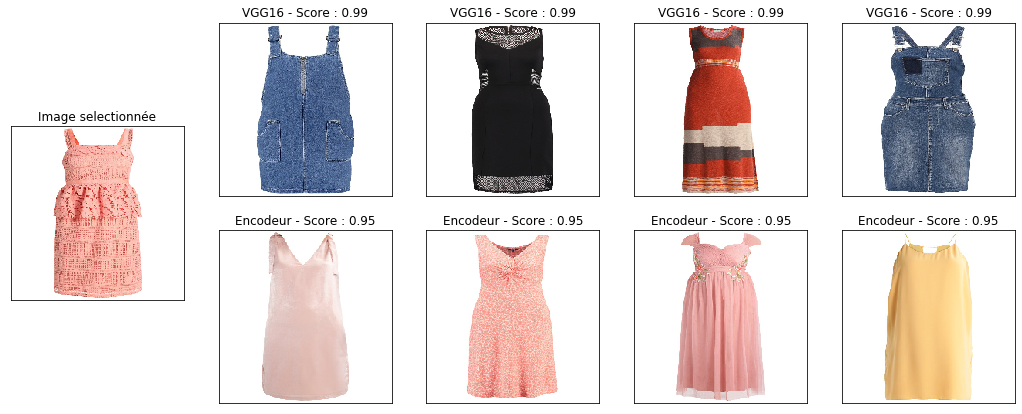

__________________________________________ Image numéro : 18 __________________________________________


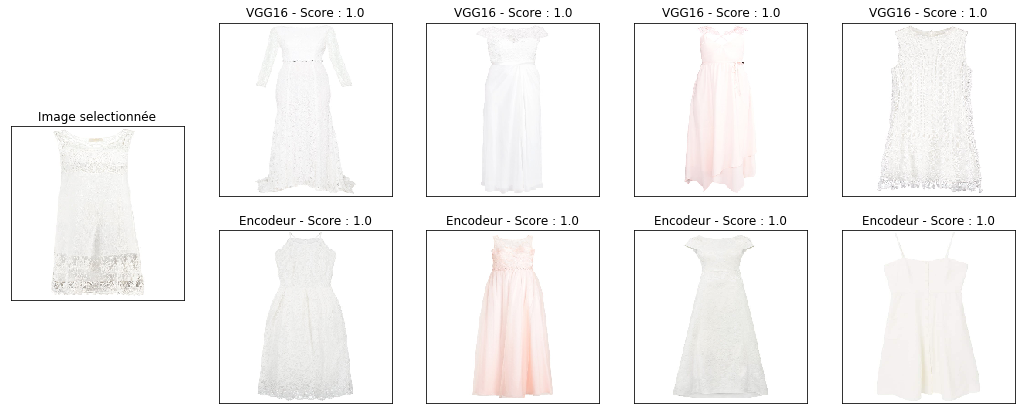

__________________________________________ Image numéro : 19 __________________________________________


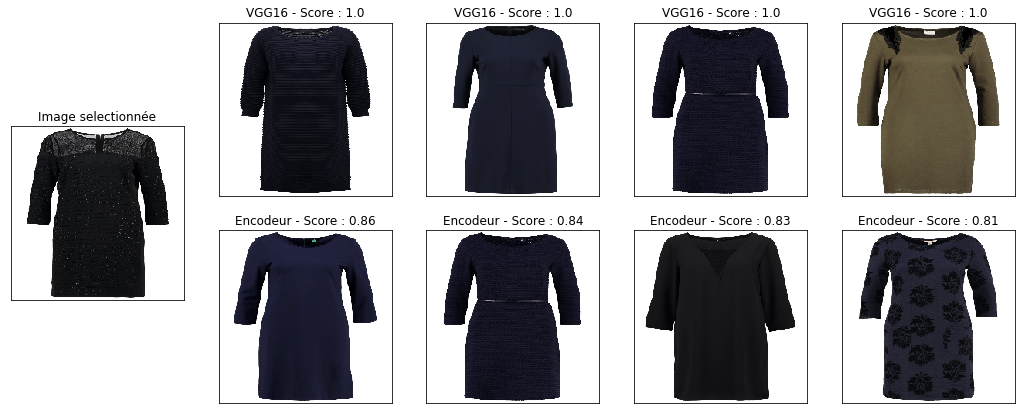

In [ ]:
for x in range(0,20):
  print("__________________________________________ Image numéro : {} __________________________________________".format(x))
  plot_similarite(image_id = x, nb_simil = 4)
